# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random

from tqdm.notebook import tqdm

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

## [Disclaimer]
Функции обратного распространения и вычисления градиента посчитаны руками, а затем имплементированы здесь. Фото расчётов:

In [2]:
class Perceptron:
        
    def __init__(self, iterations=100, n_out=1, learning_rate=1e-2):
        self.w = None # веса модели
        self.iterations = iterations # максимальное количество итераций
        self.n_out = n_out # количество выдаваемых фич
        self.learning_rate = learning_rate
    
    def _random_initialization(self, shape):
        """
        Инициализация по Xavier
        """
        
        border = np.sqrt(6) / np.sqrt(shape + self.n_out)
        self.w = np.random.uniform(low=-border,
                                   high=border, 
                                   size=shape + 1)
    
    @staticmethod
    def sygmoid(x):
        
        # Убираем экстремальные значения дабы избежать переполнения стека
        if x < 0:
            x = max(-100, x)
        else:
            x = min(100, x)
        return 1 / (1 + np.exp(-x))
        
    def _compute_grad(self, predicted_label, true_label, feature_vector):
        y_hat_minus_y = np.ones(self.w.shape[0]) * (predicted_label - true_label)
        
        features = np.eye(self.w.shape[0]) * feature_vector
        
        gradients_wrt_x_i = features @ y_hat_minus_y
        
        return gradients_wrt_x_i
        
    
    def forward_propagation(self, feature_vector):
        passed_value = feature_vector @ self.w
        
        y_hat = self.sygmoid(passed_value)
        return y_hat
    
    
    def backward_propagation(self, hypothesis, true_label, feature_vactor):
        gradient = self._compute_grad(hypothesis, true_label, feature_vactor)

        self.w -= self.learning_rate * gradient
    
    def fit(self, X, y):
            self._random_initialization(X.shape[1])

            X_concat = np.c_[np.ones(X.shape[0]), X] # Добавляем единичные фичи на первое место

            for iteration in tqdm(range(self.iterations)):
                if (self.predict(X) == y).sum() != X.shape[0]: # Выход, если все уже правильно классифицируется
                    for x_i, y_i in zip(X_concat, y):

                        hypothesis = self.forward_propagation(x_i)            
                        self.backward_propagation(hypothesis, y_i, x_i)

                else:
                    break
                

    def predict(self, X):
        
        X_concat = np.c_[np.ones(X.shape[0]), X]
        
        # Прогон даных через перцептрон для вычисления гипотезы - тут основано на сигмоиде, поэтому трешхолд=0.5
        h = np.array([
            self.forward_propagation(x_i) > 0.5 for x_i in X_concat 
        ]).astype(int)
        
        
        
        return h

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [3]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        if pts:
            x, y = list(zip(*pts))
            plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

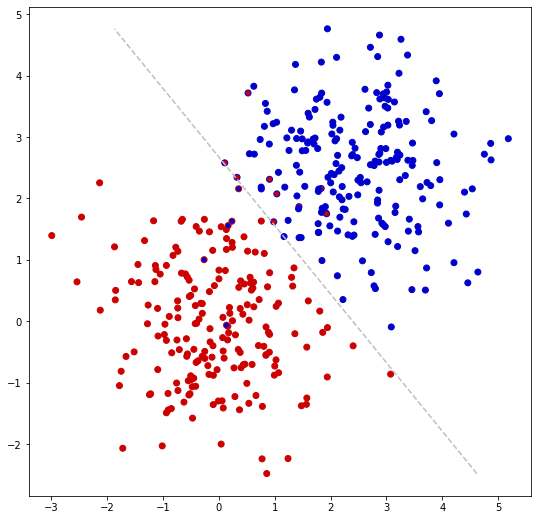

In [4]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
predictions = np.array(c.predict(X))
visualize(X, true_labels, predictions, c.w)

  0%|          | 0/100 [00:00<?, ?it/s]

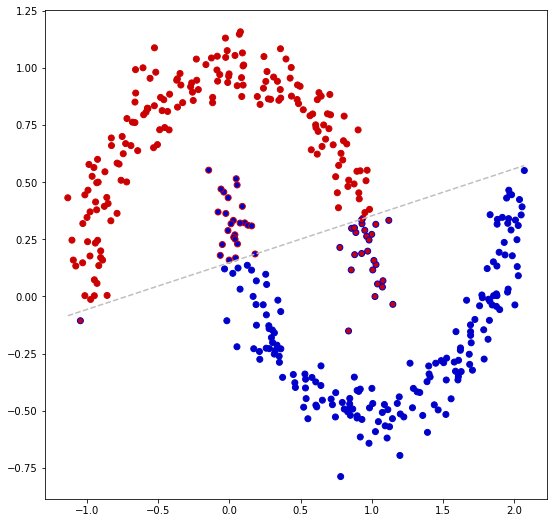

In [5]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
pred = np.array(c.predict(X))
visualize(X, true_labels, pred, c.w)
#print(np.mean(pred == true_labels))

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [6]:
class PerceptronBest(Perceptron):
    def __init__(self, **params):
        super().__init__(**params)

    def fit(self, X, y):
        self._random_initialization(X.shape[1])
        X_concat = np.c_[np.ones(X.shape[0]), X]
        
        # Сохраняем состояние весов
        best_w = self.w.copy()
        best_error = float("inf")
        
        for iteration in tqdm(range(self.iterations)):
            if (self.predict(X) == y).sum() != X.shape[0]:
                for x_i, y_i in zip(X_concat, y):

                    hypothesis = self.forward_propagation(x_i)

                    self.backward_propagation(hypothesis, y_i, x_i)
                
                # Считаем предсказания и ошибки на них для данного набора весов
                predictions_on_current_iteration = self.predict(X)
                
                error = (predictions_on_current_iteration != y).sum()
                
                
                # Если ошибка меньше, чем минимальная ошибка из прошлого => сохраняем текущие веса
                # Если больше, то оставляем текущие веса без изменений
                if error > best_error:
                    self.w = best_w.copy()

                else:
                    best_w = self.w.copy()
                    best_error = error
            else:
                break

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

  0%|          | 0/100 [00:00<?, ?it/s]

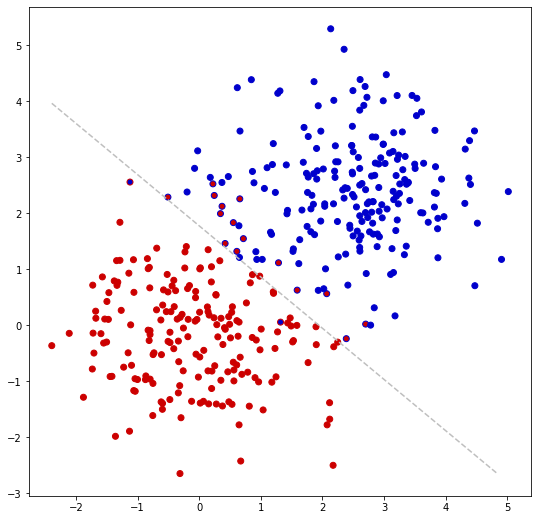

0.9575


In [7]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)
print(np.mean(np.array(c.predict(X)) == true_labels))

  0%|          | 0/100 [00:00<?, ?it/s]

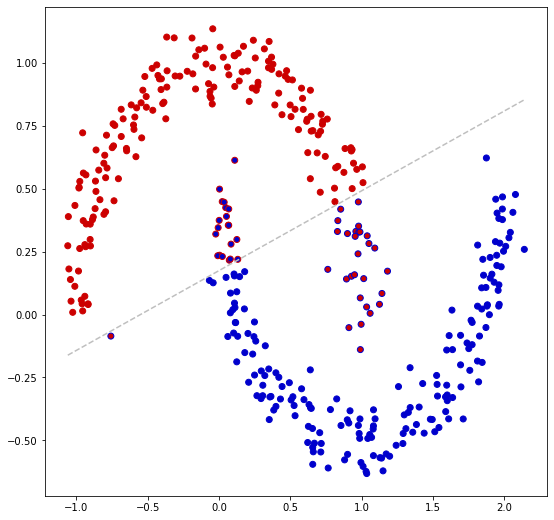

0.8775


In [98]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)
print(np.mean(np.array(c.predict(X)) == true_labels))

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [111]:
def transform_images(images) -> np.ndarray:
    """
    
    returns: images_data n x 2
    n - количество данных
    2 - количество фич
    * 1-я фича - количество ненулевых пикселей сверху от побочной диагонали
    * 2-я фича - количество ненулевых пикселей снизу от побочной диагонали
    
    Побочная диагональ не учитывается
    """
    images_data = []
    
    for image in images:
        upper_anti_triangular_image_convolution = np.count_nonzero(np.triu(np.fliplr(image), 1)) 
        
        lower_anti_triangular_image_convolution = np.count_nonzero(np.tril(np.fliplr(image), -1)) 
    
        images_data.append([upper_anti_triangular_image_convolution, lower_anti_triangular_image_convolution])
        

    
    return np.array(images_data)
        
    

def get_digits(train_image_ids, test_image_ids):
    data = datasets.load_digits()
    images_train, labels_train = data.images[train_image_ids['ImageId'].values], data.target[train_image_ids['ImageId'].values]
    images_test, labels_test = data.images[test_image_ids['ImageId'].values], data.target[test_image_ids['ImageId'].values]
    return images_train, labels_train, images_test, labels_test

def get_digits_by_mask(images, labels, y0, y1):
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    return images, labels

def get_x_y(train_image_ids, test_image_ids, y0=1, y1=5):
    X_train, y_train, X_test, y_test = get_digits(train_image_ids, test_image_ids)

    X_train, y_train = get_digits_by_mask(X_train, y_train, y0, y1)

    X_train = transform_images(X_train)
    
    X_test, y_test = get_digits_by_mask(X_test, y_test, y0, y1)
    X_test = transform_images(X_test)

    return X_train, y_train, X_test, y_test

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [112]:
train_ids, test_ids = pd.read_csv("./HW_Perceptron_data/x_digits_train.csv"), pd.read_csv("./HW_Perceptron_data/x_digits_test.csv")
X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids)

In [113]:
y_train[y_train == 5] = 0
y_test[y_test == 5] = 0

In [114]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [90]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

  0%|          | 0/100000 [00:00<?, ?it/s]

Accuracy: 0.7808219178082192


In [102]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = #YOUR CODE
submission["Expected"] = #YOUR CODE
submission.to_csv('submission.csv', index=False)

SyntaxError: invalid syntax (607722207.py, line 2)

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [109]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0 + 1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = Perceptron(iterations=20000)
    
    y_train[y_train == y0] = 0
    y_test[y_test == y0] = 0
    
    
    y_train[y_train == y1] = 1
    y_test[y_test == y1] = 1
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))